In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv
/kaggle/input/gdz-elektrik-datathon-2023/med.csv
/kaggle/input/gdz-elektrik-datathon-2023/train.csv


In [2]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
dftrain = pd.read_csv("/kaggle/input/gdz-elektrik-datathon-2023/train.csv",parse_dates=True)
dfmed = pd.read_csv("/kaggle/input/gdz-elektrik-datathon-2023/med.csv")
dfsubmiss = pd.read_csv("/kaggle/input/gdz-elektrik-datathon-2023/sample_submission.csv")
dftrain.set_index("Tarih",inplace=True)
dftrain                 

,Dağıtılan Enerji (MWh)
Tarih,
2018-01-01 00:00:00,1593.944216
2018-01-01 01:00:00,1513.933887
2018-01-01 02:00:00,1402.612637
2018-01-01 03:00:00,1278.527266
2018-01-01 04:00:00,1220.697701
...,...
2022-07-31 19:00:00,2492.489498
2022-07-31 20:00:00,2479.958245
2022-07-31 21:00:00,2485.016884


In [4]:
dftrain.index = pd.to_datetime(dftrain.index)
dftrain.reset_index(inplace=True)

In [5]:
dftrain['Tarih'] = dftrain['Tarih'].dt.to_period('M')
dftrain

,Tarih,Dağıtılan Enerji (MWh)
0,2018-01,1593.944216
1,2018-01,1513.933887
2,2018-01,1402.612637
3,2018-01,1278.527266
4,2018-01,1220.697701
...,...,...
40147,2022-07,2492.489498
40148,2022-07,2479.958245
40149,2022-07,2485.016884
40150,2022-07,2396.574255


In [6]:
dfMonth = dftrain.groupby("Tarih")['Dağıtılan Enerji (MWh)'].sum().reset_index().set_index("Tarih")
dfMonth

,Dağıtılan Enerji (MWh)
Tarih,
2018-01,1.426880e+06
2018-02,1.198419e+06
2018-03,1.199236e+06
2018-04,1.077336e+06
2018-05,1.191347e+06
2018-06,1.288838e+06
2018-07,1.614309e+06
2018-08,1.577075e+06
2018-09,1.289557e+06


<AxesSubplot:xlabel='Tarih'>

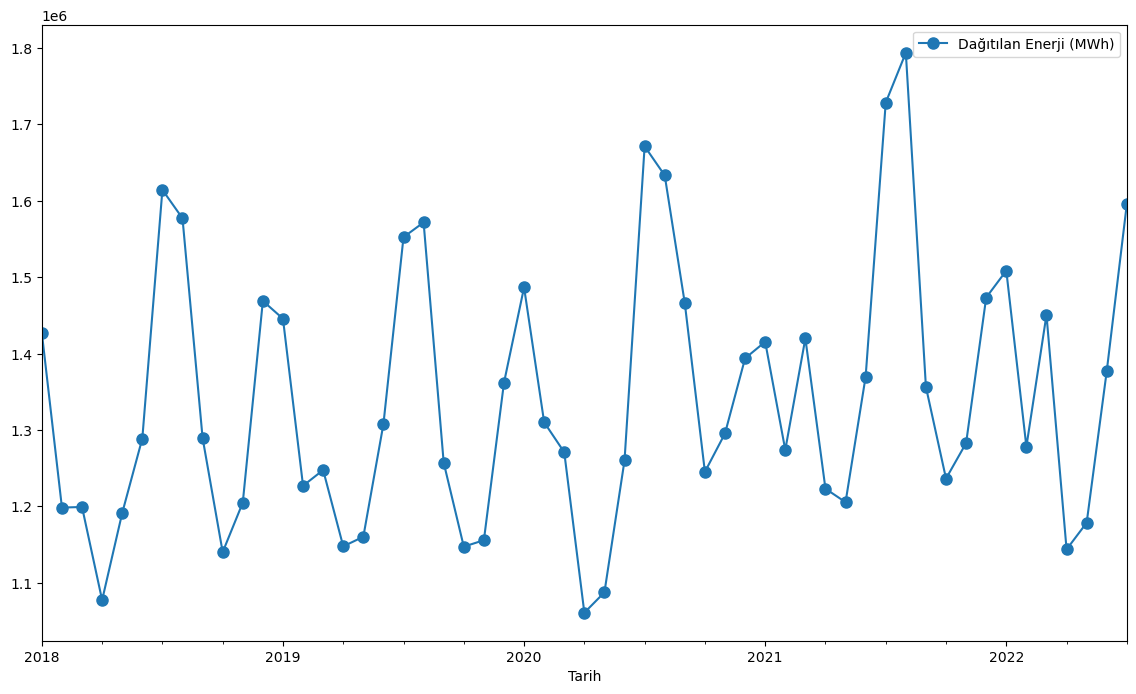

In [7]:
dfMonth.plot(figsize=(14,8),marker="o",markersize=8)

Adfuller durağanlık testi zaman serilerinde trend olup olmadığını kontrol etmektedir.<br>
Eğer p-value değeri 0.05 ten küçükse verinin durağan olduğunu söyleyebiliriz.<br>


In [8]:
df = dfMonth


from statsmodels.tsa.stattools import adfuller
result = adfuller(df)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))



ADF Statistic: -0.336503
p-value: 0.920173
Critical Values:
	1%: -3.593
	5%: -2.932
	10%: -2.604


<AxesSubplot:xlabel='Tarih'>

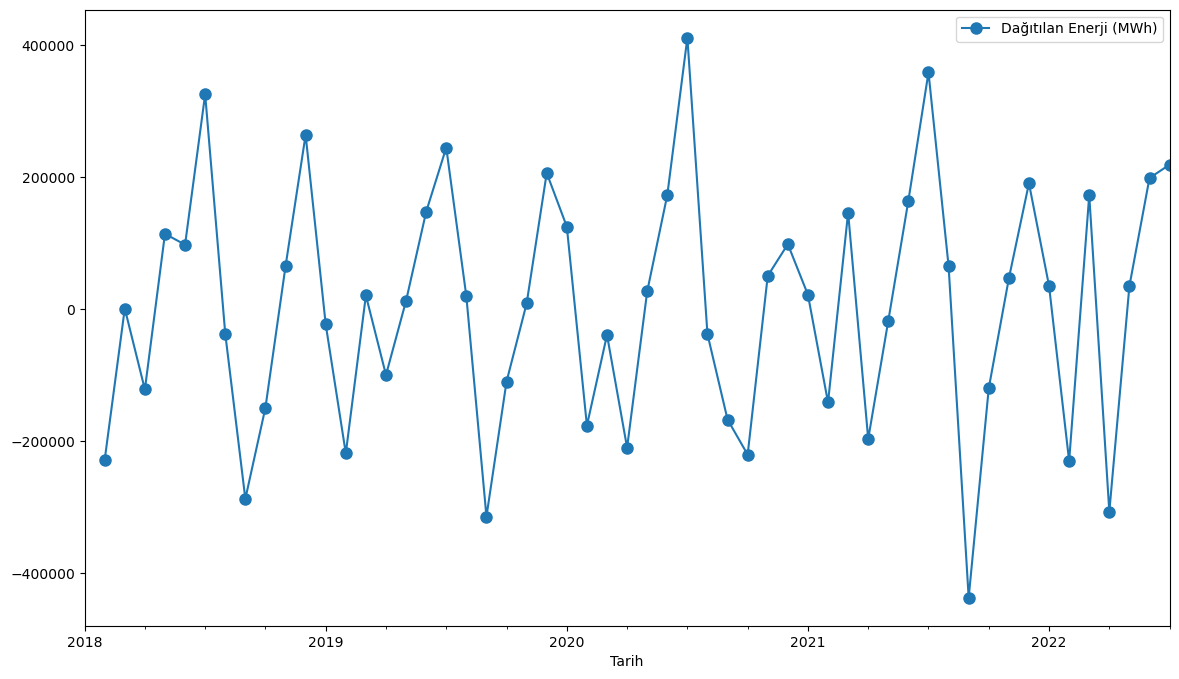

In [9]:
dfMonth.diff().plot(figsize=(14,8),marker="o",markersize=8)

In [10]:
#Birinci dereceden fark alındığında verinin p-value değeri 0.02 olarak bulunmuştur.
#Modele d = 1 değeri eklenmelidir.

from statsmodels.tsa.stattools import adfuller

result = adfuller(dfMonth.diff().dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.164486
p-value: 0.022135
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605


In [11]:
#model = SARIMAX(df,order=(2,1,2) ,seasonal_order = (1,1,0,12) ) mape = 5,17

model = SARIMAX(df,order=(2,1,2) ,seasonal_order = (1,1,0,12) )
model_f = model.fit()

model_f.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22789D+01    |proj g|=  5.17834D+00

At iterate    5    f=  9.73499D+00    |proj g|=  8.12206D-02

At iterate   10    f=  9.72936D+00    |proj g|=  1.12103D-02


 This problem is unconstrained.



At iterate   15    f=  9.72604D+00    |proj g|=  3.91943D-03

At iterate   20    f=  9.72603D+00    |proj g|=  1.56145D-04

At iterate   25    f=  9.72592D+00    |proj g|=  5.91107D-03

At iterate   30    f=  9.72586D+00    |proj g|=  7.21064D-04

At iterate   35    f=  9.72577D+00    |proj g|=  2.85824D-03

At iterate   40    f=  9.72570D+00    |proj g|=  9.41381D-04

At iterate   45    f=  9.72569D+00    |proj g|=  6.12026D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     54      1     0     0   5.458D-06   9.726D+00
  F =   9.7256937188143393     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:              Dağıtılan Enerji (MWh)   No. Observations:                   55
Model:             SARIMAX(2, 1, 2)x(1, 1, [], 12)   Log Likelihood                -534.913
Date:                             Sun, 16 Apr 2023   AIC                           1081.826
Time:                                     08:31:35   BIC                           1092.252
Sample:                                 01-31-2018   HQIC                          1085.648
                                      - 07-31-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1763      0.579      0.305      0.761      -0.958       1.311
ar.L2          0.8025      0.653      1.230      0.219      -0.477       2.081
ma.L1         -0.2210      0.689     -0.321      0.748      -1.572       1.130
ma.L2         -0.7727      0.766     -1.009      0.313      -2.274       0.729
ar.S.L12      -0.1406      0.096     -1.459      0.144      -0.329       0.048
sigma2      7.398e+09   2.85e-10   2.59e+19      0.000     7.4e+09     7.4e+09
===================================================================================
Ljung-Box (L1) (Q):                   3.94   Jarque-Bera (JB):                 0.97
Prob(Q):                              0.05   Prob(JB):                         0.62
Heteroskedasticity (H):               4.71   Skew:                            -0.20
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+36. Standard errors may be unstable.
"""

In [12]:

df = dfMonth

Egitim = df[:40]
Test = df[40:]

start = len(Egitim)
end = len(Egitim) + len(Test)-1
predict = model_f.predict(start=start,end = end,typ='levels').rename('Test_Data').astype('int')
predict = pd.DataFrame(predict)

In [13]:
Test['Dağıtılan Enerji (MWh)'].sum()/predict['Test_Data'].sum()

0.9856583166381719

In [14]:

def Mape_Degeri(tahmin, test):
    mape = np.mean(np.abs(tahmin - test)/np.abs(test))*100  # MAPE
            # ACF1
    return mape
mape = Mape_Degeri(np.array(list(predict['Test_Data'])), np.array(list(Test['Dağıtılan Enerji (MWh)'])))
print("MAPE değeri {} olarak bulunmuştur. ".format(round(mape,2)))

MAPE değeri 5.17 olarak bulunmuştur. 


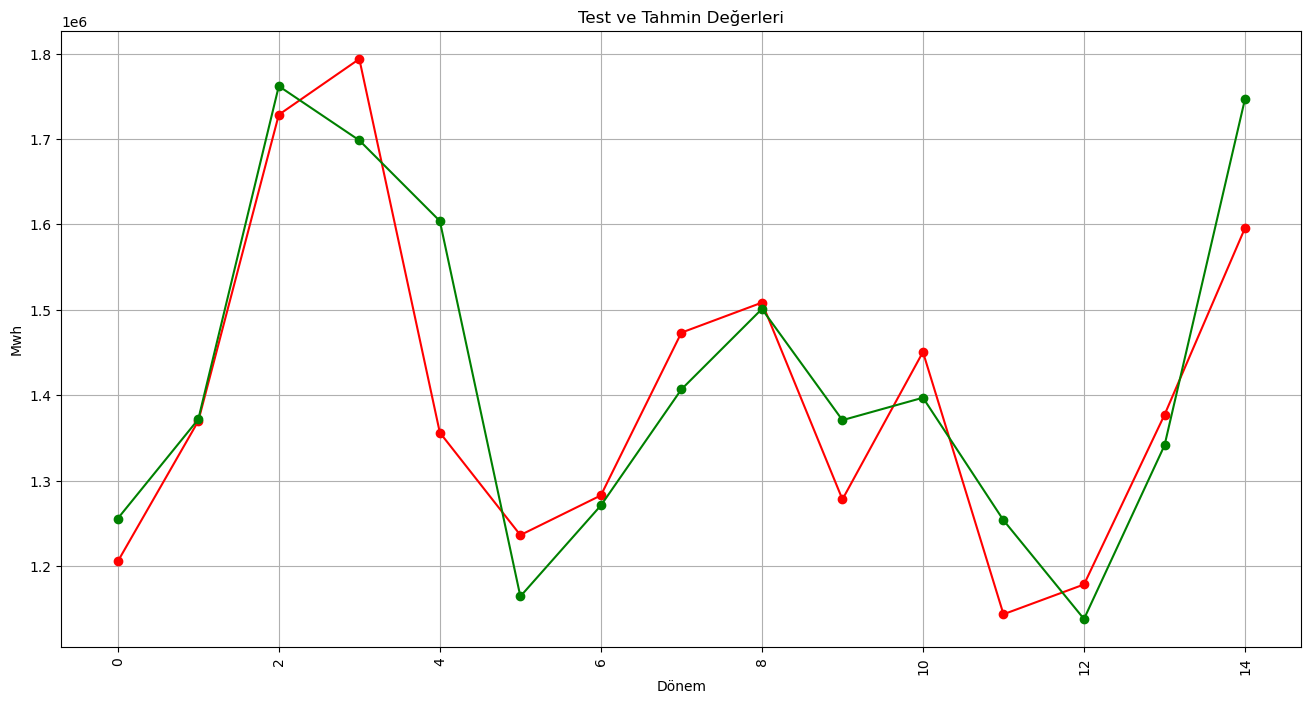

In [15]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(list(Test["Dağıtılan Enerji (MWh)"]),marker='o',color='red')
ax.plot(list(predict["Test_Data"]),marker='o',color='green')

ax.set(xlabel='Dönem', ylabel='Mwh',
       title='Test ve Tahmin Değerleri')
ax.grid()

plt.xticks(rotation = 90)
plt.show()

In [16]:
tahminx = model_f.forecast(steps=1).rename('Mwh').astype('int')
tahmin = pd.DataFrame(tahminx)
tahmin

,Mwh
2022-08,1652809


In [17]:
df = pd.read_csv("/kaggle/input/gdz-elektrik-datathon-2023/train.csv",parse_dates=True)
df

,Tarih,Dağıtılan Enerji (MWh)
0,2018-01-01 00:00:00,1593.944216
1,2018-01-01 01:00:00,1513.933887
2,2018-01-01 02:00:00,1402.612637
3,2018-01-01 03:00:00,1278.527266
4,2018-01-01 04:00:00,1220.697701
...,...,...
40147,2022-07-31 19:00:00,2492.489498
40148,2022-07-31 20:00:00,2479.958245
40149,2022-07-31 21:00:00,2485.016884
40150,2022-07-31 22:00:00,2396.574255


In [18]:
df08 = df[(df['Tarih'] > "2021-08-01") & (df['Tarih'] < "2021-09-01")]
df08

,Tarih,Dağıtılan Enerji (MWh)
31392,2021-08-01 00:00:00,2571.230740
31393,2021-08-01 01:00:00,2422.247527
31394,2021-08-01 02:00:00,2286.023672
31395,2021-08-01 03:00:00,2173.951400
31396,2021-08-01 04:00:00,2085.294765
...,...,...
32131,2021-08-31 19:00:00,2538.809761
32132,2021-08-31 20:00:00,2572.939106
32133,2021-08-31 21:00:00,2484.682803
32134,2021-08-31 22:00:00,2348.579241


In [19]:
df08["Dağıtılan Enerji (MWh)"].sum()

1793768.2071000002

In [20]:
df08['Saatlik%'] = df08['Dağıtılan Enerji (MWh)']/df08["Dağıtılan Enerji (MWh)"].sum()
df08['Tahmin'] = tahmin['Mwh'][0]
df08['Sonuc'] = df08['Saatlik%']*df08['Tahmin']
df08

,Tarih,Dağıtılan Enerji (MWh),Saatlik%,Tahmin,Sonuc
31392,2021-08-01 00:00:00,2571.230740,0.001433,1652809,2369.176403
31393,2021-08-01 01:00:00,2422.247527,0.001350,1652809,2231.900698
31394,2021-08-01 02:00:00,2286.023672,0.001274,1652809,2106.381686
31395,2021-08-01 03:00:00,2173.951400,0.001212,1652809,2003.116359
31396,2021-08-01 04:00:00,2085.294765,0.001163,1652809,1921.426604
...,...,...,...,...,...
32131,2021-08-31 19:00:00,2538.809761,0.001415,1652809,2339.303153
32132,2021-08-31 20:00:00,2572.939106,0.001434,1652809,2370.750521
32133,2021-08-31 21:00:00,2484.682803,0.001385,1652809,2289.429639
32134,2021-08-31 22:00:00,2348.579241,0.001309,1652809,2164.021467


In [21]:
dfsubmiss['Dağıtılan Enerji (MWh)']=list(df08['Sonuc'])
dfsubmiss

,Tarih,Dağıtılan Enerji (MWh)
0,2022-08-01 00:00:00,2369.176403
1,2022-08-01 01:00:00,2231.900698
2,2022-08-01 02:00:00,2106.381686
3,2022-08-01 03:00:00,2003.116359
4,2022-08-01 04:00:00,1921.426604
...,...,...
739,2022-08-31 19:00:00,2339.303153
740,2022-08-31 20:00:00,2370.750521
741,2022-08-31 21:00:00,2289.429639
742,2022-08-31 22:00:00,2164.021467


In [22]:
dfsubmiss.to_csv('submission.csv', index = False)